In [1]:
import pickle 

In [3]:
cd /gpfs/commons/groups/nygcfaculty/PySeq/20210323_4i4color/pipeline/20210323_4i4color

/gpfs/commons/groups/nygcfaculty/PySeq/20210323_4i4color/pipeline/20210323_4i4color


In [4]:
ls

anndata/            masks/             summary_m3b.yaml  test_directory3/
cell_neighborhood/  net_neighborhood/  tables/           test_directory4/
final_zarr/         processed_zarr/    test/             test_directory5/
intensities/        raw_zarr/          test_directory1/
logs/               summary_m1a.yaml   test_directory2/


In [5]:
cd intensities

/gpfs/commons/groups/nygcfaculty/PySeq/20210323_4i4color/pipeline/20210323_4i4color/intensities


In [6]:
ls


m1a.pkl  m3b.pkl


In [7]:
cd /gpfs/commons/groups/nygcfaculty/PySeq/mouse_genotype/20210428_mouse_genotype_2/

/gpfs/commons/groups/nygcfaculty/PySeq/mouse_genotype/20210428_mouse_genotype_2


In [8]:
ls

anndata/     intensities/  mouse_genotype2.yaml  summary_m387ntga1.yaml
exp_conf/    logs/         processed_zarr/       summary_m387ntga2.yaml
final_zarr/  masks/        raw_zarr/


In [9]:
cd intensities

/gpfs/commons/groups/nygcfaculty/PySeq/mouse_genotype/20210428_mouse_genotype_2/intensities


In [10]:
ls

m387ntga2.pkl


In [11]:
with open('m387ntga2.pkl', 'rb') as handle:
    data = pickle.load(handle)

In [12]:
data

{}

In [13]:
cd masks

[Errno 2] No such file or directory: 'masks'
/gpfs/commons/groups/nygcfaculty/PySeq/mouse_genotype/20210428_mouse_genotype_2/intensities


In [14]:
ls

m387ntga2.pkl


In [24]:
cd ..

/gpfs/commons/groups/nygcfaculty/PySeq/mouse_genotype/20210428_mouse_genotype_2


In [26]:
cd final_zarr

/gpfs/commons/groups/nygcfaculty/PySeq/mouse_genotype/20210428_mouse_genotype_2/final_zarr


In [27]:
ls

m387ntga1.zarr/  picasso_m387ntga1.yaml
m387ntga2.zarr/  picasso_m387ntga2.yaml


In [39]:
import matplotlib
import skimage
labels = skimage.io.imread('/gpfs/commons/groups/nygcfaculty/PySeq/mouse_genotype/20210428_mouse_genotype_2/masks/m387ntga2.tiff')

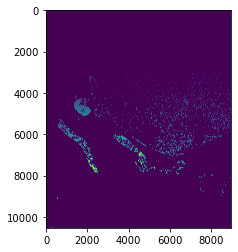

In [21]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [23]:
import numpy as np
np.max(img)

5132

In [91]:
import xarray as xr
image = xr.open_zarr('/gpfs/commons/groups/nygcfaculty/PySeq/mouse_genotype/20210428_mouse_genotype_2/final_zarr/m387ntga2.zarr').to_array()

In [30]:
marker_list = ['LMN1b', 'GFAP','ELAVL2','MBP','PVALB']

In [37]:
plane_dict = {}
for mark in marker_list:
    try:
        plane_dict.update({mark: image.sel(marker = mark)})
    except:
        pass

In [68]:
import torch
def get_mean_intensity(pl):
        result_ar = np.zeros(mx)
        tr = torch.from_numpy(pl.astype(np.float))
        print(np.shape(tr))
        for r in range(mx):
            result_ar[r] = (tr[lab == r+1]).float().mean()
        return result_ar

lab = torch.from_numpy(labels.astype(np.float))
mx = np.max(labels)

mean_intensity_per_marker = {}
for plane in plane_dict.keys():
    pl = plane_dict[plane].values
    mean_int = get_mean_intensity(pl)
    mean_intensity_per_marker.update({plane:mean_int})

with open(snakemake.output[0], 'wb') as f:
    pickle.dump(mean_intensity_per_marker, f)


torch.Size([1, 10, 10532, 8960])


IndexError: The shape of the mask [10532, 8960] at index 0 does not match the shape of the indexed tensor [1, 10, 10532, 8960] at index 0

In [67]:
np.shape(tr)

NameError: name 'tr' is not defined

In [92]:
image = image.squeeze().drop_vars('variable').rename('m387ntga2')

In [93]:
image

<xarray.DataArray 'm387ntga2' (marker: 13, obj_step: 10, row: 10532, col: 8960)>
dask.array<getitem, shape=(13, 10, 10532, 8960), dtype=uint16, chunksize=(1, 1, 10532, 1792), chunktype=numpy.ndarray>
Coordinates:
    channel   (marker) int64 dask.array<chunksize=(4,), meta=np.ndarray>
    cycle     (marker) int64 dask.array<chunksize=(4,), meta=np.ndarray>
  * marker    (marker) <U7 'LMNB1_1' 'ELAVL2' 'GFAP' ... 'PDGFRA' 'MBP'
  * obj_step  (obj_step) int64 8028 8263 8498 8733 8968 ... 9438 9673 9908 10143
Dimensions without coordinates: row, col

In [97]:
imo = image.sel(marker = 'LMNB1_1')

In [100]:
v = imo.as_numpy()

In [101]:
np.shape(v)

(10, 10532, 8960)

In [59]:
import cellpose
from cellpose import core, models, io
from pathlib import Path
import imageio
import xarray as xr

# Open image from zarr store
image = xr.open_zarr('/gpfs/commons/groups/nygcfaculty/PySeq/mouse_genotype/20210428_mouse_genotype_2/masks/)

# Start logger
#smk_logger = get_logger(image.name, filehandler = snakemake.log[0])
#smk_logger.debug(image)

# Make sure only 1 objective step
if 'obj_step' in image.dims and 'obj_step' not in snakemake.config.get('segmentation',{}):
    if image.obj_step.size > 1:
        mid_step = image.obj_step[image.obj_step.size//2]
        image = image.sel(obj_step = mid_step)
        smk_logger.debug(image)

# segment
logger = io.logger_setup()
use_GPU = core.use_gpu()
smk_logger.info(f'Using GPU: {use_GPU}')
model = models.CellposeModel(gpu=use_GPU,model_type='TN2')
#model = models.CellposeModel(model_type='TN2')
# Remove once priors steps in pipe
#one_z_plane = image.sel(obj_step = 8498, channel = 558, cycle=1)
arr = image.sel(snakemake.config.get('segmentation'))
channels = [0,0]
masks, flows, styles = model.eval(arr.values, diameter=None, channels=channels, cellprob_threshold= -6, flow_threshold= 1000)
imageio.imwrite(snakemake.output[0],masks)

NameError: name 'snakemake' is not defined